In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
from lib.scikitComponents import *
import itertools
import collections

# LDA

## Data preprocessing

Load all data, build a list of class labels using DMOZ top-level classes

In [3]:
# Load in the previously created corpus and dictionary of scraped sites
dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl', stemmed=True, prefix="stemmed_")

Done.


In [4]:
# Link topics to URLs
meta = list(zip(dmoz_data['urls'], dmoz_data['dmoz_categories']))
# Build array of class labels
classes, top_categories, dmoz_encoder = datastuff.encode_dmoz_categories(dmoz_data['dmoz_categories'])
# Set up datasets
X = dmoz_data['meta']
y = classes

## Define a classification pipeline for the corpus data

The Pipeline() object chains together objects from the lib.scikitComponents file, so that they can be used as part of a scikit-learn classification pipeline

Define a classifier (decision trees), and chain the preprocessing step to the classifier

In [5]:
# classifier = sklearn.svm.LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#      verbose=0)

# classifier = sklearn.svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
# gamma=0.0, kernel='rbf', max_iter=-1, probability=False, random_state=None,
# shrinking=True, tol=0.001, verbose=False)

classifier = sklearn.ensemble.ExtraTreesClassifier(random_state=0, n_estimators=100, oob_score=True, bootstrap=True, n_jobs=4)
# Use stem=True to remove word suffixes
builder = MetaMatrixBuilder()
clf = sklearn.pipeline.Pipeline([
    ('sanitiser', MetaSanitiser(stem=False, meta_selection_flags=13)),
    ('matrix_builder', builder),
    ('classification', classifier)])

## Run the classifier

We can use the meta corpus or the full body corpus here, just by replacing a single argument

The data is split in to training and test sets, and then fit to the training set. The LDA model is generated ***only*** from the training set, not the testing set.

In [6]:
scores = sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.39 (+/- 0.07)


In [7]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(np.array(X), classes)

## Do some analysis
### Find the score for each category. 

Note that if the classifier assigned *random* categories, the score would be $\frac{1}{\textrm{num categories}}$. Instead, it is actually quite high in some cases, indicating a moderate amount of success (given how naive this is!)

In [8]:
model = clf.fit(X_train, y_train)
print model.score(X_test, y_test)
predicted = model.predict(X_test)
print sklearn.metrics.classification_report(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)

0.513333333333
             precision    recall  f1-score   support

       arts       0.61      0.39      0.47        44
   business       0.40      0.56      0.46        45
  computers       0.66      0.59      0.62        59
      games       0.57      0.63      0.60        19
     health       0.46      0.46      0.46        24
       home       0.52      0.42      0.46        31
kids and teens       0.44      0.37      0.40        19
       news       0.60      0.60      0.60        40
 recreation       0.53      0.17      0.26        46
  reference       0.41      0.56      0.47        34
   regional       0.00      0.00      0.00         0
    science       0.56      0.50      0.53        56
   shopping       0.66      0.59      0.62        32
    society       0.41      0.16      0.23        44
     sports       0.48      0.78      0.59       107

avg / total       0.52      0.51      0.50       600



/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Is there a correlation between test-set proportion and score?

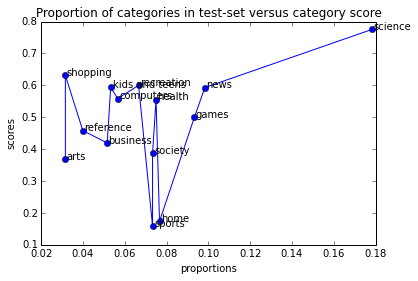

In [9]:
analysis.plot_proportion_investigation(predicted, dmoz_encoder, y_test)

### Which things get mistaken for other things?

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


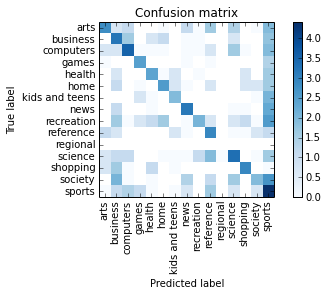

[[17  2  3  0  0  1  0  3  1  5  0  4  0  1  7]
 [ 0 25  5  0  2  3  0  1  1  0  0  2  0  0  6]
 [ 2  2 35  1  1  1  0  1  1  2  0  5  1  0  7]
 [ 1  0  0 12  0  0  0  1  0  1  0  0  0  0  4]
 [ 0  2  0  0 11  1  2  0  1  0  0  0  2  0  5]
 [ 0  3  0  1  0 13  2  1  0  2  0  0  2  2  5]
 [ 0  0  0  2  1  0  7  0  0  0  0  0  0  1  8]
 [ 0  3  0  0  1  0  0 24  0  0  0  1  1  0 10]
 [ 0  5  1  2  3  5  0  1  8  2  0  2  3  1 13]
 [ 3  2  0  0  0  0  2  1  0 19  0  1  1  2  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  3  3  0  0  1  1  1  3  7  1 28  0  1  5]
 [ 2  5  1  0  3  0  1  0  0  0  0  0 19  0  1]
 [ 0  8  1  0  1  0  0  4  0  3  0  5  0  7 15]
 [ 1  3  4  3  1  0  1  2  0  5  0  2  0  2 83]]


In [10]:
cm = sklearn.metrics.confusion_matrix(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)
analysis.plot_confusion_matrix(np.log(cm), labels= dmoz_encoder.classes_)
plt.show()
print cm

## Searching over parameters using GridSearch...

Which combination of keywords, description and key phrases should we use? Let's check every combination!

- It seems that we want to use **description**, **keywords**, and **title**, but not **keyphrases** (flags = 13).
- The worst single feature is **keyphrases**.
- The single best feature is **keywords**
- Adding **keyphrases** seems to decrease the accuracy!


In [11]:
# Gridsearch
from sklearn.grid_search import GridSearchCV
param_grid = dict(sanitiser__meta_selection_flags=[1, 2, 4, 5, 7, 8, 9, 12, 13, 15])
search = GridSearchCV(clf, param_grid=param_grid, n_jobs=4)
search.fit(X, classes)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('sanitiser', MetaSanitiser(meta_selection_flags=13, stem=False)), ('matrix_builder', MetaMatrixBuilder(min_word_count=4)), ('classification', ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_...estimators=100, n_jobs=4,
           oob_score=True, random_state=0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid={'sanitiser__meta_selection_flags': [1, 2, 4, 5, 7, 8, 9, 12, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [12]:
print search.best_params_

{'sanitiser__meta_selection_flags': 13}


In [13]:
search.grid_scores_

[mean: 0.28691, std: 0.00626, params: {'sanitiser__meta_selection_flags': 1},
 mean: 0.21726, std: 0.00568, params: {'sanitiser__meta_selection_flags': 2},
 mean: 0.28357, std: 0.00914, params: {'sanitiser__meta_selection_flags': 4},
 mean: 0.33862, std: 0.01369, params: {'sanitiser__meta_selection_flags': 5},
 mean: 0.33778, std: 0.00939, params: {'sanitiser__meta_selection_flags': 7},
 mean: 0.26647, std: 0.00674, params: {'sanitiser__meta_selection_flags': 8},
 mean: 0.33486, std: 0.00590, params: {'sanitiser__meta_selection_flags': 9},
 mean: 0.33361, std: 0.00670, params: {'sanitiser__meta_selection_flags': 12},
 mean: 0.38032, std: 0.00682, params: {'sanitiser__meta_selection_flags': 13},
 mean: 0.37823, std: 0.00223, params: {'sanitiser__meta_selection_flags': 15}]

In [14]:
trf = MetaSanitiser(stem=False, meta_selection_flags=15).fit_transform(X)
m = MetaMatrixBuilder(min_word_count=4)
count = collections.defaultdict(int)
for name, empty in zip(dmoz_encoder.inverse_transform(classes), np.sum(m.fit_transform(trf), axis=1)==0):
    count[name] += 1 if empty else 0
print "Number of documents with no metadata: {}".format(np.sum(np.sum(m.fit_transform(trf), axis=1)==0))
for x in count:
    print x, count[x]
print "Meta-data-less documents get predicated as: \"{}\"".format(dmoz_encoder.inverse_transform(search.best_estimator_.predict([{}]))[0])

Number of documents with no metadata: 173
arts 14
regional 0
shopping 1
business 10
reference 12
science 15
computers 14
recreation 10
kids and teens 3
sports 41
society 14
games 7
health 13
home 8
news 11
Meta-data-less documents get predicated as: "sports"


#### Separate pipelines for keywords/title seem to make no difference

In [15]:
feature_meta = sklearn.pipeline.Pipeline([
    ('sanitiser', MetaSanitiser(stem=False, meta_selection_flags=5)),
    ('matrix_builder', builder)])

feature_title = sklearn.pipeline.Pipeline([
    ('sanitiser', MetaSanitiser(stem=False, meta_selection_flags=8)),
    ('matrix_builder', builder)])
feature_union = sklearn.pipeline.FeatureUnion([
    ('meta', feature_meta),
    ('title', feature_title)])
clf_union = sklearn.pipeline.Pipeline([
    ('union', feature_union),
    ('classifier', clf)])

scores = sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.39 (+/- 0.07)
